# Kaggle Contest: Housing Price Estimator
The object of this exercise is to use the data set provided to train a machine learning model to predict the price of a house. This notebook will compare a decision tree classifier with a tensorflow decision forest to estimate price. Output will be from the TFDF and submitted for scoring.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# trying ideas presented in
# https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf

from datetime import date
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_bool_dtype
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import LocalOutlierFactor
np.random.seed(42)
from numpy.random import default_rng
ranger = default_rng()
plt.rcParams['figure.dpi'] = 110
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input_dir = "../input/house-prices-advanced-regression-techniques/"

../input/house-prices-advanced-regression-techniques/sample_submission.csv
../input/house-prices-advanced-regression-techniques/data_description.txt
../input/house-prices-advanced-regression-techniques/train.csv
../input/house-prices-advanced-regression-techniques/test.csv


### Read in the data

In [2]:
# Load the data
train_data = pd.read_csv(input_dir + "train.csv")
test_data = pd.read_csv(input_dir + "test.csv")
sample_data = pd.read_csv(input_dir + "sample_submission.csv")

In [3]:
# Get lists of column names based on their data type
quantitative = [f for f in train_data.columns if train_data.dtypes[f] !='object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train_data.columns if train_data.dtypes[f] == 'object']

In [4]:
# Do one hot encoding on categorical/qualitative features
train_dummies = pd.get_dummies(train_data[qualitative])
train_ready = train_data[quantitative].join(train_dummies)
train_ready.fillna(value=0, inplace=True)

In [5]:
test_dummies = pd.get_dummies(test_data[qualitative])
test_ready = test_data[quantitative].join(test_dummies)
test_ready.fillna(value=0, inplace=True)

In [6]:
# gather feature names common to both training and testing sets. This step is important because the one-hot 
# encoding creates a different set of new features for training and testing data based on the contents of 
# the categorical feature columns.
train_list = train_ready.columns.to_list()
test_list = test_ready.columns.to_list()
features = list(set(train_list).intersection(test_list))

## Outlier Removal

In [7]:
# Identify outliers in the training data
LOFer = LocalOutlierFactor()
LOF = LOFer.fit_predict(train_ready[features])

In [8]:
# Remove outliers from the training data
train_ready["LOF"] = LOF
LOFindex = train_ready[train_ready["LOF"] == -1].index.to_list()
train_ready.drop(index=LOFindex, inplace=True)
print("train_ready shape: ", train_ready.shape, " size of LOF ", LOF.shape)

train_ready shape:  (1394, 289)  size of LOF  (1460,)


## Prepare data for use with tensorflow

In [9]:
# Check the tensorflow versions
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.9.2
TensorFlow Decision Forests v0.2.7


In [10]:
train_data_tf = train_data.drop("Id", axis=1)

In [11]:
# get the data from the training set into TF format
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data_tf, label=label, task = tfdf.keras.Task.REGRESSION)

/opt/conda/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


# Model Section
Trying a decision tree regressor from sklearn

In [12]:
dtreg = DecisionTreeRegressor(random_state=42)
X = train_ready[features]
y = train_data["SalePrice"].drop(index=LOFindex)

dtreg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [13]:
yhat = dtreg.predict(X)

In [14]:
# plot the predicted prices versus the actual prices from the sklearn model
comparison = train_data[["Id","SalePrice"]].drop(index=LOFindex).copy()
comparison["PredictedPrice"] = yhat
comparison.head()

,Id,SalePrice,PredictedPrice
0,1,208500,208500.0
1,2,181500,181500.0
2,3,223500,223500.0
3,4,140000,140000.0
4,5,250000,250000.0


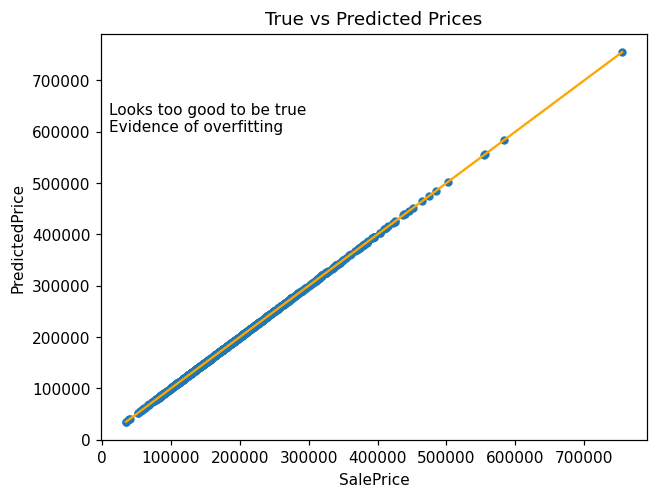

In [15]:
# plot the predicted vs. actual prices from the training data set for review
comparison.sort_values(by="SalePrice", inplace=True)
minp = comparison["SalePrice"].min()
maxp = comparison["SalePrice"].max()
linp = np.linspace(minp,maxp)
comparison.plot(x="SalePrice", y="PredictedPrice",kind='scatter',use_index=False, title="True vs Predicted Prices")
plt.plot(linp,linp, c='orange')
plt.annotate("Looks too good to be true\nEvidence of overfitting",(10000,600000))
plt.show()

Trying the tensorflow decision forest estimator in regression mode

In [16]:
# create the model instance
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics



Use /tmp/tmpd4qj333g as temporary training directory


In [17]:
# train the model
rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:07.756738. Found 1460 examples.
Training model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmpd4qj333g/model/ with prefix d4a7ebbf5fe44192


Model trained in 0:00:03.146684
Compiling model...


[INFO abstract_model.cc:1248] Engine "RandomForestOptPred" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [18]:
yhat = rf.predict(train_ds)

2/2 [==============================] - 0s 29ms/step


In [19]:
# plot the predicted prices versus the actual prices from the sklearn model
comparison = train_data[["Id","SalePrice"]].copy()
comparison["PredictedPrice"] = yhat
comparison.head()

,Id,SalePrice,PredictedPrice
0,1,208500,207077.218750
1,2,181500,179882.703125
2,3,223500,220095.765625
3,4,140000,163506.140625
4,5,250000,276130.625000


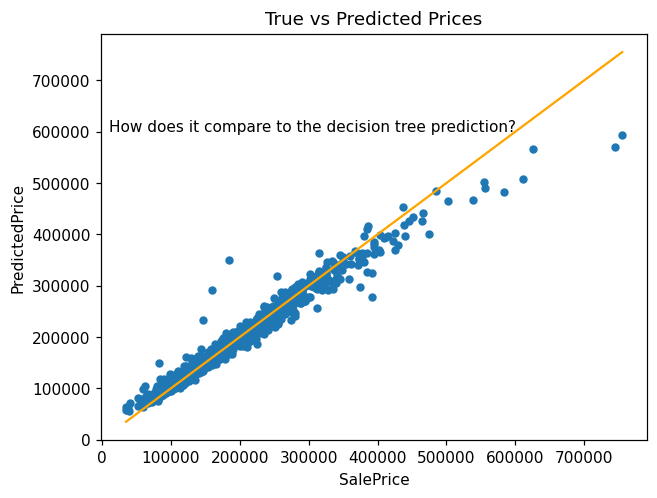

In [20]:
# plot the predicted vs. actual prices from the training data set for review
comparison.sort_values(by="SalePrice", inplace=True)
minp = comparison["SalePrice"].min()
maxp = comparison["SalePrice"].max()
linp = np.linspace(minp,maxp)
comparison.plot(x="SalePrice", y="PredictedPrice",kind='scatter',use_index=False, title="True vs Predicted Prices")
plt.plot(linp,linp, c='orange')
plt.annotate("How does it compare to the decision tree prediction?",(10000,600000))
plt.show()

In [21]:
# Make the prediction
id = test_data.pop("Id")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, task = tfdf.keras.Task.REGRESSION)
yhat = rf.predict(test_ds)

2/2 [==============================] - 1s 27ms/step


In [22]:
submit_data = pd.DataFrame({'Id': id,
                           "SalePrice": yhat.squeeze()})

submit_data.head()

,Id,SalePrice
0,1461,126322.164062
1,1462,154300.687500
2,1463,180256.484375
3,1464,184319.218750
4,1465,193974.781250


<AxesSubplot:title={'center':"Prices From Model's Prediction"}, xlabel='Id', ylabel='SalePrice'>

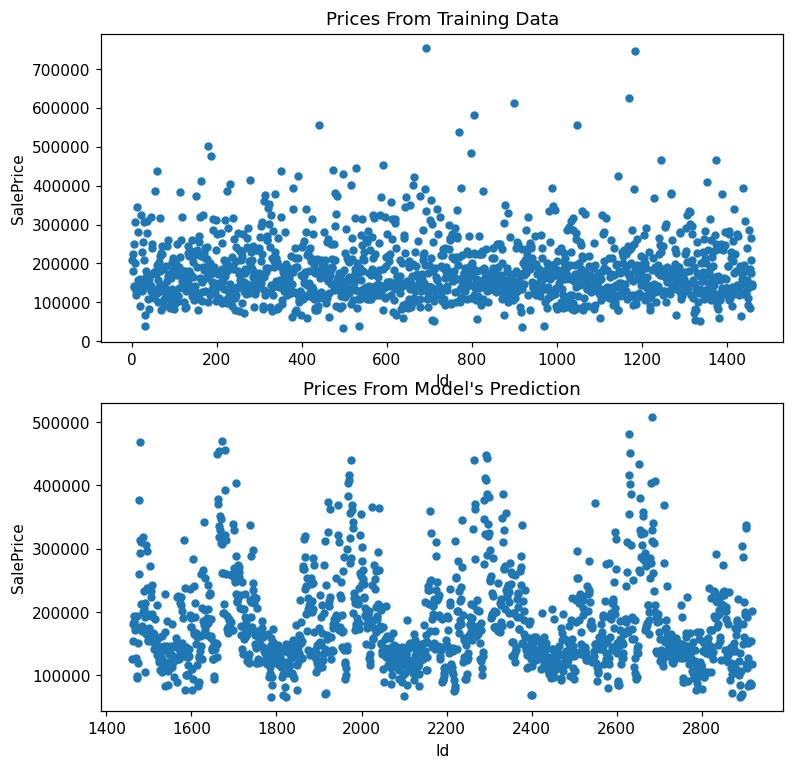

In [23]:
# Create plots of true prices from the training data and predicted prices from
# the test data to see whether we're in the ballpark.
fig, ax = plt.subplots(2, figsize=(8,8))
train_data.plot(x="Id", y="SalePrice", kind='scatter', ax=ax[0], title="Prices From Training Data")
submit_data.plot(x="Id", y="SalePrice", kind='scatter', ax=ax[1], title="Prices From Model's Prediction")

In [24]:
# Write the submission file 
submit_data.to_csv("submission.csv", index=False)

# Conclusion
Without all the preprocessing needed for sklearn.DecisionTreeRegressor() the tensorflow decision forest yielded acceptable predictions in sample without evidence of overfitting.

